HW2 testing bench  

In [1]:
import numpy as np
import heapq as h
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import pdb
import math
import math as m
import random
import time

In [2]:
#LOAD DATA:

# LOAD DATA:
Bronze_data = np.loadtxt("Bronze.txt", dtype=float, delimiter=',')
Silver_data = np.loadtxt("Silver.txt", dtype=float, delimiter=',')
Gold_data = np.loadtxt("Gold.txt", dtype=float, delimiter=',')
Platinum_data = np.loadtxt("Platinum.txt", dtype=float, delimiter=',')

print('Bronze_data Range \t=', np.min(Bronze_data[:, 1]), '<->', np.max(Bronze_data[:, 1]))
print('Silver_data Range \t=', np.min(Silver_data[:, 1]), '<->', np.max(Silver_data[:, 1]))
print('Gold_data Range \t=', np.min(Gold_data[:, 1]), np.max(Gold_data[:, 1]))
print('Platinum_data Range \t=', np.min(Platinum_data[:, 1]), '<->', np.max(Platinum_data[:, 1]))

Y_range_Cu = (np.min(Bronze_data[:, 1]), np.max(Bronze_data[:, 1]))
Y_range_Ag = (np.min(Silver_data[:, 1]), np.max(Silver_data[:, 1]))
Y_range_Au = (np.min(Gold_data[:, 1]), np.max(Gold_data[:, 1]))
Y_range_Pt = (np.min(Platinum_data[:, 1]), np.max(Platinum_data[:, 1]))



Bronze_data Range 	= -15.249988 <-> 27.0
Silver_data Range 	= 0.0 <-> 6.868231
Gold_data Range 	= -0.409776 0.41609
Platinum_data Range 	= -6.24986 <-> 2.797242


In [3]:
class Function_node(object):
    # Globals to be inherited
    # last is the header indicator (indexing from 1!)
    node_types = ('+', '-', '*', '/', '^', 'sin', 'cos',
                  'const', 'x', 'X', 'var', 'ERR')
    dual_operators = ('+', '-', '*', '/', '^')
    single_operators = ('sin', 'cos')

    # TODO

    def __init__(self, function_name, value=None):
        self.num_childs = 0
        self.value = value
        # assigning a name in our accepted list
        try:
            if function_name not in self.node_types:
                raise ValueError(
                    F"Invalid input: {function_name}. Please enter a valid node type \n\n\t run> heap.node_types for the list")
            else:
                self.function_name = function_name
        except ValueError as err_msg:
            # print(err_msg)
            self.function_name = 'ERROR'
            sys.exit()  # exit if there is an issue

        # set number of children gien type

        '''
        if self.function_name == 'const':
            if value == None:
                self.value = 0  # TODO: np.random.uniform(yrange)
            else:
                self.value = value
        '''

        if self.function_name in self.dual_operators:
            self.req_num_childs = 2
        elif self.function_name in self.single_operators:
            self.req_num_childs = 1
        else:
            self.req_num_childs = 0
    
    # METHODS:
    def add_child_count(self):
        self.num_childs += 1
        
    def can_add_child(self):
        return self.num_childs < self.req_num_childs
    
    def copy_node(self):
        #returns a copy of the node
        new_node = Function_node(function_name = self.function_name,
                                 value = self.value)
        new_node.num_childs = self.num_childs
        return new_node

    def __str__(self):  # print statement
        if self.function_name == 'const':
            return f"{self.value}"
        elif self.function_name in ['var', 'x', 'X']:
            if self.value:
                return f"x={self.value}"
            else:
                return "X"
        else:
            return f"{self.function_name}"

In [7]:
class NP_Heap(Function_node):
    def __init__(self, length=2):
        self.heap = np.full(length, None, dtype=object)
        # ALL Operators ('+', '-', '*', '/', '^', 'sin', 'cos')
        self.operators = ('*', '+', '-')
        self.trig_operators = ('sin', 'cos')
        self.non_operator = ('x', 'const')

    def __str__(self):
        return self.print_heap_tree()

 ############# Heap Manipulation #############

    # INDEXING AT 1:
    def get_parent_idx(self, child_idx):
        return int(child_idx/2)

    def get_parent(self, child_idx):
        parent_idx = self.get_parent_idx(child_idx)
        return self.heap[parent_idx]

    def get_left_child_idx(self, parent_idx):
        return 2 * parent_idx

    def get_right_child_idx(self, parent_idx):
        return 2 * parent_idx + 1

    def get_left_child(self, parent_idx):
        left_child = self.heap[self.get_left_child_idx(parent_idx)]
        return left_child

    def get_right_child(self, parent_idx):
        right_child = self.heap[self.get_right_child_idx(parent_idx)]
        return right_child

    def get_children_idx(self, parent_idx):
        return 2*parent_idx, 2*parent_idx+1

    def get_children(self, parent_idx):
        return self.heap[2*parent_idx], self.heap[2*parent_idx+1]

    def get_children_type(self, parent_idx):
        L, R = self.get_children(parent_idx)
        return type(L), type(R)

    def depth(self):
        deepest_node_ind = max(np.arange(self.heap.size)[self.heap != None])
        return int(m.floor(m.log2(deepest_node_ind)))

    def has_root(self):
        if self.heap[0] == None:
            return False
        else:
            return True

    def copy(self):
        #ERROR HERE! WE had to not just initialize a new heap but also the nodes themselves... duh....
        h = NP_Heap(length = self.heap.size)
        
        for i,node in enumerate(self.heap):
            if node == None: 
                h.heap[i] = None
            else: 
                h.heap[i] = node.copy_node()
        return h

    # Why not just do this?
    # def has_root(self):
    #   return self.heap[0] != None

 # INSERT FUNCTION

    def insert(self, parent_indx, node_obj, position=None):
        # check for size availibility or resize

        # check heap length if short, doubles array until acceptable
        while self.heap.size - 1 < self.get_right_child_idx(parent_indx):
            #print('doubled',self.heap.size ,self.get_right_child_idx(parent_indx)  )
            self.heap = np.append(self.heap,
                                  np.full(self.heap.size, None).astype(Function_node))

        L_indx, R_indx = self.get_children_idx(parent_indx)

        # if a position is provided it will insert WITH REPLACEMENT
        if position:
            if position == 'L':
                self.heap[L_indx] = node_obj
            elif position == 'R':
                self.heap[R_indx] = node_obj
            else:
                print("invalid arg position = 'L' or 'R'")

        # if no position provided it will insert left to right if a child is empty
        elif not self.heap[L_indx]:
            self.heap[L_indx] = node_obj
        elif not self.heap[R_indx]:
            self.heap[R_indx] = node_obj

        else:  # insert to the left child. #TODO: implement recursive insert.
            print('ERROR: Parent children filled')
            #self.insert(self,parent_indx = L, value = value )
        return None

 # ---------------------------------------------

 ####### DISPLAY FUNCTIONS ##########
    def print_heap_tree(self, index=1, prefix="", is_left=True):  # CALLED BY __str__ method
        output = ""
        if index < len(self.heap) and self.heap[index] is not None:
            # Process right child first (going down)
            output += self.print_heap_tree(index=2*index+1, prefix=prefix + (
                "|   " if is_left else "    "), is_left=False)
            # Add the current node to the output
            output += prefix + "|-- " + str(self.heap[index]) + "\n"
            # Process left child
            output += self.print_heap_tree(index=2*index, prefix=prefix + (
                "|   " if not is_left else "    "), is_left=True)
        # else:
            # Indicate the absence of a node with [...]
            # output += prefix + "|-- [...]\n"
        return output

    def print_arr(self):  # shows the heap and indexes
        heap_str = [str(node) for node in self.heap]
        ind_arr = np.arange(self.heap.size)
        max_def = max(ind_arr[self.heap != None])+1
        print(np.stack((ind_arr[1:max_def], heap_str[1:max_def])))
        return None

    def show_function(self):  # TODO
        # evaluates a node given its index
        heap_str = [str(node) for node in self.heap]
        depth = None  # some function of length (1/2)
        function_str = None
        return None

    def plot_approximation(self, X_range=(0, 10), target_data=None, y_pred=None, ):
        X_arr = np.linspace(X_range[0], X_range[1], 1000)

        if type(target_data) != None:
            plt.plot(target_data[:, 0], target_data[:, 1])

        if not y_pred:
            y_pred = [self.evaluate(X=x) for x in X_arr]

        plt.plot(X_arr, y_pred, 'b')
        plt.show()
        return None
 # ---------------------------------------------

 ####### Main functionalities ###########
    def Random_Heap(self, Index=1, max_depth=2, const_prob=.5, C_range=(0, 10)):
        '''
        this is a function that will be called recursively to build valid trees to every index
            - Start at a given index (default is root = 1) initialized as an operator
                - If not initialized it assigns a random operator. 
            - given operator type, select the number of required children (can = req chlds > chlds)
            for each:
                - Check for termination criteria that make the children of that node constants
                    --> either some random probability or a maximum depth is reached
                - if not terminated, select a random operator
                insert that node left to right into the parent children 
                - note that the node was added so the can add child is accurate. 

        '''

        # initialize root.
        if self.heap[Index] == None:
            self.heap[Index] = Function_node(np.random.choice(self.operators))
        while self.heap[Index].can_add_child():  # TODO TEST
            # TODO heap depth
            if self.depth() > max_depth - 1 or np.random.rand() < const_prob:  # no operators terminate with constants
                node_name = np.random.choice(['x', 'const'])
                node_val = np.random.uniform(
                    C_range[0], C_range[1]) if node_name == 'const' else None
            else:
                node_name = np.random.choice(self.operators)
                node_val = None

            new_node = Function_node(function_name=node_name, value=node_val)
            self.insert(parent_indx=Index, node_obj=new_node)
            # note the addition of a child to break while loop
            self.heap[Index].add_child_count()

        L_child, R_child = self.get_children(Index)
        # self.print_arr()
        if L_child.function_name in self.operators:
            self.Random_Heap(2*Index)
        if R_child.function_name in self.operators:
            self.Random_Heap(2*Index+1)

    # ****  EVALUATE A NODE ***:
    def evaluate(self, node_ind=1, X=None):  # tree root = 1
        # evaluates a node given its index
        def node_operation(operator, operand):
            if operator == '+':
                return operand[0]+operand[1]
            elif operator == '-':
                return operand[0] - operand[1]
            elif operator == '*':
                return operand[0] * operand[1]
            elif operator == '/':
                return operand[0] / operand[1]
            elif operator == '^':
                return operand[0] ** operand[1]
            elif operator == 'sin':
                return np.sin(operand)
            elif operator == 'cos':
                return np.cos(operand)

        # MAIN LOOP:

        L_child, R_child = self.get_children(node_ind)
        L_indx, R_indx = self.get_children_idx(node_ind)
        children_types = self.get_children_type(node_ind)

        # CHECKS left child, if an operator, evaluate recursively returning a constant. If X, assign it.

        # checks for None leaf
        if type(L_child) is None:
            pass

        elif L_child.function_name in self.operators:
            L_child.value = self.evaluate(node_ind=2*node_ind, X=X)

        elif L_child.function_name in ['var', 'x', 'X']:
            L_child.value = X

        if type(R_child) is None:
            pass

        elif R_child.function_name in self.operators:
            R_child.value = self.evaluate(node_ind=2*node_ind+1, X=X)

        elif R_child.function_name in ['var', 'x', 'X']:
            R_child.value = X

        # terminating state: both children are constandts (floats) or Nan (with at least a constant) after being evaluated
        node_operator = self.heap[node_ind].function_name
        try:
            if Function_node not in children_types:
                raise TypeError(
                    f"Invalid children type for operator: {node_operator} \n\t L/R children are: {(L_child, R_child)}")

            # i.e its sin, cos, tan etc (as defined above
            elif node_operator in self.trig_operators:

                if None not in children_types:
                    raise ValueError(
                        f"Invalid children type for operator: {node_operator} \n\t L/R children are: {(L_child, R_child)}")
                elif type(L_child):  # if None use the right child value
                    node_val = node_operation(node_operator, L_child.value)
                elif R_child:
                    node_val = node_operation(node_operator, R_child.value)
            else:
                node_val = node_operation(
                    node_operator, (L_child.value, R_child.value))

        except ValueError as err_msg:
            sys.exit()

        # DIAGNOSTIC
        msg_out = (
            f"at the root evaluating with:\n\t - parent node index {node_ind}"
            f"\n\t - operator {node_operator}"
            f"\n\t - with children {[str(x) for x in self.heap[[L_indx, R_indx]]]}"
            f"\n result passed {node_val}"
        )
        # print(msg_out)
        return node_val
    # **** END NODE EVAL   ***

    def MSE(self, point_cloud, plotting=False):
        # RECALL: MSE = (1/n) * Σ(actual – forecast) ^2
        X_arr = point_cloud[:, 0]
        y = point_cloud[:, 1]
        y_pred = np.array([self.evaluate(X=x) for x in X_arr])
        MSE = np.sum(np.square(y_pred-y)/y.shape[0])

        if plotting:
            self.plot_approximation(X_arr, y_pred, y_true=y)
        return MSE

 # EP: MUTATION ########## :
    '''
        IDEAS: 
            - Most vanilla: search through heap for the constants and +_ by X small % of the value
            - Adding operations: for chain terminating variables, replace them with the + operator 
                                 and add a small constant to the variable
            - Mutation schedules: annealing or adaptive mutation (increases if stagnating decreases if progress)
            - Optimization by consolidating into one function so we dont have to traverse heap. (in practice heap should be small!)
    '''

    def Constant_Mutation(self, change_prcnt=.02, min_mutation_range = .05 ):  # TODO newar zero increase mutation size
        # small change to constants and addition/substraction to variables
        # basic: for node in heap, if name = const +_ X%
        for node in self.heap:
            if type(node) == Function_node and node.function_name == 'const':
                R       = abs(change_prcnt*node.value)
                Range   = max(R,min_mutation_range) #makes sure the change is at least a min for near zero constant
                node.value += random.uniform(-1*Range,Range)
        return self

    def Operator_mutation(self, number):
        for i, node in enumerate(self.heap):
            if type(node) == Function_node:  # only operate over nodes....
                if node.function_name == '*':
                    self.print_arr()
                    node.function_name = '/'
                    self.print_arr()
        return None

    ##### BLOAT PROBLEM ####
    # TODO  self.depth() and getting nodes at a maximum depth
    def depth_consolidation(self, max_depth=5):
        if self.depth() > max_depth:
            for node in self.heap[max_depth]:
                # calculate averave value and consolidate the node to this value. conditional for large stdv?
                print('Need to implement')
        return None

    def pruning(self):  # TODO
        # deletes useless tree (tree that evaluates to 1 for a mult child or a 0 for a + child/sin cos delete)
        return None

    def hoist_mutation(self):  # TODO
        # Chooses a tree that evaluates to the same constant through x-range and replaces it by the constant
        return None

    def subtree(self, indx):
        subtree_ind = [indx]
        subtree_depth = self.depth() - int(m.floor(m.log2(indx)))  # heap depth - node depth
        for i in range(1, subtree_depth+1):
            for j in range(indx*2**i, (indx+1)*2**i):
                subtree_ind.append(j)
        return subtree_ind, self.heap[subtree_ind]

In [11]:
## RANDOM SEARCH: 
def Random_Search(evaluations, data, max_depth=3, const_prob=.5, C_range=(-10, 10)):
    MSE_log = []
    best_solution = None

    best_function_err = 1e9
    for i in range(evaluations):
        function = NP_Heap(length=32)
        function.Random_Heap(max_depth=max_depth,
                             const_prob=const_prob,
                             C_range=C_range)
        MSE_i = function.MSE(data)
        if MSE_i < best_function_err:
            best_solution = function
            best_function_err = MSE_i
            MSE_log.append([i, MSE_i])

    return best_solution, np.array(MSE_log)

In [12]:
start = time.time()
function, mse_arr = Random_Search(2000,
                                  data=Bronze_data,
                                  max_depth=3,
                                  C_range=Y_range_Cu)
runtime = time.time() - start


181.2681803703308
|   |-- x=10.0
|-- *
    |   |-- 7.2829692643686865
    |-- -
        |-- x=10.0



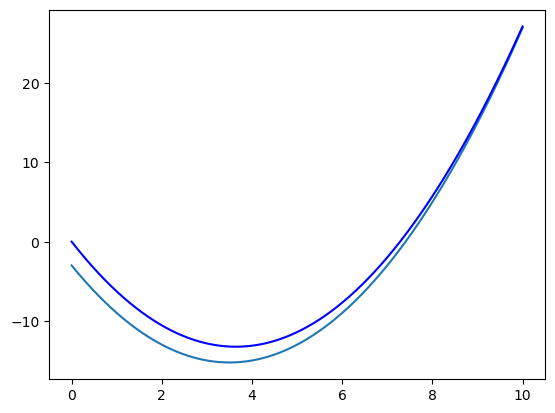

In [13]:
print(runtime)
print(function)

function.plot_approximation(target_data=Bronze_data)

In [ ]:
def HC(target_data, step_search_size=128, max_depth=3, mutate_prcnt_change=.01,
       const_prob=.5, C_range=(-10, 10), given_function=None, Optimized_random = 50):
    '''
    This function will search random children and move in the best direction from an optimized random start. 

    '''
    if not given_function: 
        # initialize return functions
        if Optimized_random: #does a quick random search to eliminate the trash #TODO diversity issue this should be deliberately implemented at the random function level
            Best_Function, _ = Random_Search(evaluations = 47,
                                        data=target_data,
                                        max_depth=max_depth,
                                        C_range=C_range)
        else: 
            Best_Function = NP_Heap(length=32)
            Best_Function.Random_Heap(max_depth=max_depth,
                                        const_prob=const_prob,
                                        C_range=C_range)
    else: Best_Function = given_function
    
    Min_MSE  = Best_Function.MSE(target_data)
    MSE_log  = []
    Improved = True
    step_num = 0
    while Improved:
        Improved = False  # to be flagged true if any of the children is better than the parent
        # parent of all children to search steps based on the curent best
        gen_parent = Best_Function.copy()
        for _ in range(step_search_size):
            # loops N times testing nearby points
            step = gen_parent.copy()
            step.Constant_Mutation(change_prcnt=mutate_prcnt_change)
            step_MSE = step.MSE(target_data)
            if step_MSE < Min_MSE:
                # this will track best step at a position.
                Best_Function = step
                Min_MSE = step_MSE
                Improved = True  # only needs to happen once to be overritedn
        step_num += 1
        MSE_log.append([step_num*step_search_size, Min_MSE])

        print('loop ',step_num, ' DONE' )
        #print('Best child \n',Best_Function)
        print('min MSE', Min_MSE)

    return Best_Function, MSE_log
# Random starts
def RSHC(Starts, target_data, step_search_size=128, max_depth=3, mutate_prcnt_change=.02,
         const_prob=.5, C_range=(-10, 10), Optimized_random = True):
    
    improvement_log = []
    total_evals = 0
    Best_MSE = 1e7
    best_function = None
    for i in range(Starts):
        print('**** START = ',i,' *****')
        function, mse_arr = HC(step_search_size=step_search_size,
                                target_data=target_data,
                                mutate_prcnt_change= mutate_prcnt_change,
                                max_depth=max_depth,
                                const_prob=const_prob,
                                C_range=C_range,
                                Optimized_random = Optimized_random)
        evals, best_MSE_i = mse_arr[-1]
        total_evals += evals
        if best_MSE_i < Best_MSE:
            improvement_log.append([total_evals, best_MSE_i])
            best_function = function
            Best_MSE      = best_MSE_i
    return best_function, improvement_log

In [ ]:
#%% RUN RSHC 
best_function, performance_log= RSHC(Starts= 10,
                                    step_search_size=25,
                                    mutate_prcnt_change=.08,
                                    target_data=Bronze_data,
                                    max_depth=3,
                                    C_range=Y_range_Cu,
                                    Optimized_random = 100)
print(best_function, '\n MSE= ',best_function.MSE(Bronze_data))
best_function.plot_approximation(target_data=Bronze_data)

TESTING BELOW: 

In [ ]:
 # Testing random heap
R = NP_Heap()
R.Random_Heap()
R.print_arr()
print(R.depth())

[['1' '2' '3' '4' '5' '6' '7']
 ['*' '-' '-' 'X' '9.696413678646236' 'X' 'X']]
2


In [ ]:
# Testing Mutation & subtree
M1 = NP_Heap(length=2)
M1.heap[0] = Function_node('ERR')
M1.heap[1] = Function_node('+')
M1.insert(parent_indx=1, position='L', node_obj=Function_node('*'))
M1.insert(parent_indx=1, position='R',
          node_obj=Function_node('const', value=1))
M1.insert(parent_indx=2, position='L', node_obj=Function_node('sin'))
M1.insert(parent_indx=2, position='R',
          node_obj=Function_node('const', value=3.14))
M1.insert(parent_indx=3, position='L', node_obj=Function_node('var'))
M1.insert(parent_indx=3, position='R',
          node_obj=Function_node('const', value=21))
M1.Constant_Mutation()
M1.insert(parent_indx=4, position='R',
          node_obj=Function_node('const', value=2))
M1.insert(parent_indx=4, position='R',
          node_obj=Function_node('const', value=69))


M1.print_arr()
subtree, vals = M1.subtree(3)

for el, v in zip(subtree, vals):
    print(el, v)

[['1' '2' '3' '4' '5' '6' '7' '8' '9']
 ['+' '*' '1.01' 'sin' '3.1086' 'X' '21.21' 'None' '69']]
3 1.01
6 X
7 21.21
12 None
13 None
14 None
15 None


In [ ]:
t1 = NP_Heap(length = 2)
t1.heap[0] = Function_node('ERR')
t1.heap[1] = Function_node('+')
t1.insert(parent_indx = 1,position= 'L', node_obj = Function_node('sin'))
t1.insert(parent_indx = 1,position= 'R', node_obj = Function_node('const', value = 1))
t1.insert(parent_indx = 2,position= 'L', node_obj = Function_node('var'))
#t1.insert(parent_indx = 2,position= 'R', node_obj = Function_node('var'))
#t1.insert(parent_indx = 3,position= 'R', node_obj = Function_node('const', value = 3.14))



t1.evaluate(X= 0)
x_arr = np.linspace(0,10,100)

y = [t1.evaluate(X = x) for x in x_arr]
t1.heap[6] = None
t1.print_arr()
plt.plot(x_arr,y)

t1.plot_approximation(np.linspace(-5,5,100))

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

MSE =  0.0025000068119343


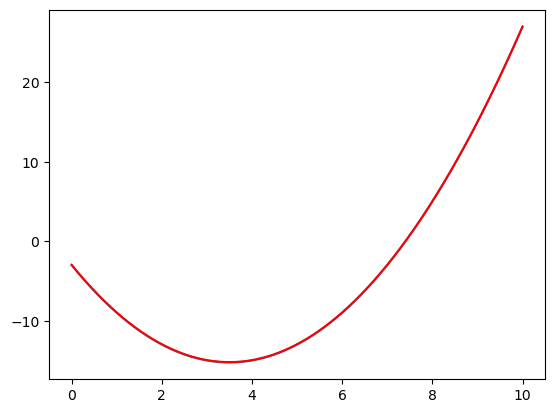

In [ ]:
data = Bronze_data
x = Bronze_data[:,0]
y = Bronze_data[:,1]
plt.plot(x,y)

y_pred = np.array([(x-3.5)**2 - 15.2 for x in Bronze_data[:,0]])
plt.plot(x,y_pred,'r')
MSE = np.sum(np.square(y_pred-y)/y.shape[0])
print('MSE = ', MSE)